# Importing libraries

In [1]:
# Import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Data Preprocessing

In [2]:
# Dataset Path
data_path = "dataset"
# Extract the class label
categories = os.listdir(data_path)
label = [i for i in range(len(categories))]
label_dict = dict(zip(categories,label))
label_dict

{'without_mask': 0, 'with_mask': 1}

In [3]:
img_size = 100
data = []
target = []

for category in categories:
    # Join folder path with category
    folder_path = os.path.join(data_path, category)
    # Storing all image name into list
    img_names = os.listdir(folder_path)
    
    # loop over the image paths
    for img_name in img_names:
        img_path = os.path.join(folder_path,img_name)
        # convert image into array
        img = cv2.imread(img_path)
        # resizing the image
        resized = cv2.resize(img, (img_size,img_size))
        
        # update the data and target lists, respectively
        data.append(resized)
        target.append(label_dict[category])

In [4]:
# convert the data to numpy array and normalized them
data = np.array(data)/255.0

# converting the target to numpy array
target = np.array(target)

# perform one-hot encoding on the labels
from tensorflow.keras import utils
target = utils.to_categorical(target)

In [5]:
print("Total No of class : {}".format(categories))
print("Total number of images : {}".format(data.shape[0]))
print("Image size and no of channel: {}".format(data.shape[1:]))
# 3 means rgb, 1 means gray image

Total No of class : ['without_mask', 'with_mask']
Total number of images : 1384
Image size and no of channel: (100, 100, 3)


### *Image Generator*

In [6]:
# this is the augmentation configuration we will use for training
augmentation = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [7]:
# split the data into train test 70% of the data for training and the remaining 20% for testing.
x_train, x_test, y_train, y_test = train_test_split(data, target,
                                                    test_size = 0.20,
                                                    random_state=42)

## Building CNN Model

In [8]:
# Start building model
model=Sequential()

# The first CNN layer followed by Relu and MaxPooling layers
model.add(Conv2D(200,(3,3), input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# The second convolution layer followed by Relu and MaxPooling layers
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer to stack the output convolutions from second convolution layer
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
# The Final layer with two outputs for two categories
model.add(Dense(2,activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 200)       5600      
_________________________________________________________________
activation (Activation)      (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 52900)             0

In [9]:
# some model parameters
EPOCHS = 20
BS = 32

In [10]:
# train the the network
history = model.fit(augmentation.flow(x_train, y_train, batch_size=BS),
                    steps_per_epoch = len(x_train) // BS,
                    validation_data = (x_test, y_test),
                    validation_steps = len(x_test) // BS,
                    epochs = EPOCHS)

Epoch 1/20
34/34 [==============================] - 32s 946ms/step - loss: 0.6425 - accuracy: 0.6214 - val_loss: 0.2984 - val_accuracy: 0.9170
Epoch 2/20
34/34 [==============================] - 31s 900ms/step - loss: 0.3812 - accuracy: 0.8484 - val_loss: 0.1667 - val_accuracy: 0.9531
Epoch 3/20
34/34 [==============================] - 31s 907ms/step - loss: 0.3040 - accuracy: 0.8805 - val_loss: 0.1462 - val_accuracy: 0.9422
Epoch 4/20
34/34 [==============================] - 34s 991ms/step - loss: 0.2885 - accuracy: 0.9023 - val_loss: 0.1241 - val_accuracy: 0.9675
Epoch 5/20
34/34 [==============================] - 34s 999ms/step - loss: 0.2259 - accuracy: 0.9191 - val_loss: 0.1357 - val_accuracy: 0.9639
Epoch 6/20
34/34 [==============================] - 33s 972ms/step - loss: 0.2335 - accuracy: 0.9237 - val_loss: 0.1200 - val_accuracy: 0.9675
Epoch 7/20
34/34 [==============================] - 31s 903ms/step - loss: 0.2315 - accuracy: 0.9219 - val_loss: 0.1006 - val_accuracy: 0.9675

# Model Evaluation

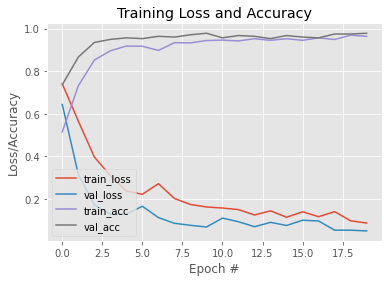

In [14]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')

In [16]:
# Model Evaluation
pred = model.predict(x_test, batch_size=BS)
pred = np.argmax(pred, axis=1)
# classification report
print(classification_report(y_test.argmax(axis=1), pred, target_names=label_dict))

              precision    recall  f1-score   support

without_mask       0.98      0.95      0.97       129
   with_mask       0.96      0.99      0.97       148

    accuracy                           0.97       277
   macro avg       0.97      0.97      0.97       277
weighted avg       0.97      0.97      0.97       277



In [17]:
# evaluation on test and train data
evaluate_testD = model.evaluate(x_test,y_test)
evaluate_trainD = model.evaluate(x_train,y_train)

print("Loss on Test Data : {}".format(evaluate_testD[0]))
print("Accuracy on Test Data : {}".format(evaluate_testD[1]))
print("==================")
print("Loss on Train Data : {}".format(evaluate_trainD[0]))
print("Accuracy on Train Data : {}".format(evaluate_trainD[1]))

35/35 [==============================] - 6s 183ms/step - loss: 0.0576 - accuracy: 0.9801
Loss on Test Data : 0.06889042258262634
Accuracy on Test Data : 0.9711191058158875
Loss on Train Data : 0.05761564522981644
Accuracy on Train Data : 0.9801264405250549


In [20]:
# save model and architecture to single file
model.save("model.h5")